Source of data: https://data.stackexchange.com/stackoverflow/query/edit/960504  
SQL request: 
   <code>SELECT Id, Body, Title, Tags, LastActivityDate, Score FROM Posts WHERE LastActivityDate > '01/01/2016' AND Tags IS NOT NULL AND Score > 10</code>

Good ressource: 
- [machinelearningplus](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) 
- [towardsdatascience](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)
  
  

01. <a href="#1.-Import-and-cleaning-data">Import and cleaning data</a>  
    1.1 <a href="#1.1-Tag-processing">Tag processing</a>  
    1.2 <a href="#1.2-Corpus-processing">Corpus processing</a>  
    1.3 <a href="#1.3-Feature-engineering">Feature engineering</a>  
02. <a href="#2.-Unsupervised-learning">Unsupervised learning</a>  
    2.1 <a href="#2.1-LDA:-LatentDirichletAllocation">LDA: LatentDirichletAllocation</a>  
    2.2 <a href="#2.2-NMF:-Negative-Matrix-Factorisation">NMF: Negative Matrix Factorisation</a>  
03. <a href="#5.-supervised-models">supervised models</a>


## 1. Import and cleaning data
The first cleaning consist mainly on removing some specific characters (":", "*", "[", ...) and html/xml tags.
The objective of this section is to build a clean list of vocabulary words that will be used in our models.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import numpy as np

In [1]:
# import data
import pandas as pd
import nltk   # Natural Language Toolkit

text = pd.concat([pd.read_csv("QueryResults2014.csv", index_col=0),
                  pd.read_csv("QueryResults2015.csv", index_col=0),
                  pd.read_csv("QueryResults2016.csv", index_col=0),
                  pd.read_csv("QueryResults2017.csv", index_col=0)])

print("text shape:", text.shape)
text.head()

text shape: (186817, 5)


,Body,Title,Tags,LastActivityDate,Score
Id,,,,,
9847880,<p>I am having trouble getting ASP.Net MVC 4 r...,"Asp.net mvc 4 on iis6: ""The page cannot be found""",<iis-6><asp.net-mvc-4>,2014-10-21 19:34:15,25
9077101,<p>I trying to use Client Side Storage availab...,"Iphone localStorage ""QUOTA_EXCEEDED_ERR"" issue",<iphone><ios><html5><local-storage>,2014-12-24 08:26:52,20
27348604,<p><strong>TL;DR</strong></p>\n\n<p>I have a t...,DynamoDB: How to distribute workload over the ...,<database><mapreduce><amazon-dynamodb>,2014-12-21 23:32:08,13
9081841,<p>I have a script that compresses my css file...,Makefile assign command output to variable,<makefile>,2014-01-27 21:41:48,17
9081846,<p>Say I have 2 files:</p>\n\n<pre><code>foo\n...,Sublime Text 2 - Auto-complete/suggest from ot...,<sublimetext>,2014-08-27 03:11:44,39


In [2]:
# to limit processing time
text_df = text

# Merge Body and Title columns
corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]

In [3]:
# clean text function
import re   # Regular expression library **
import warnings
warnings.filterwarnings('ignore')

def cleantext(raw_text):
    """clean raw text: 
           1. remove markups
           2. remove some special characters
           3. lower all"""
    
    #1. remove markups
    cleanr = re.compile('<.*?>')  
    cleantext = re.sub(cleanr, ' ', raw_text)
    
    #2. remove special characters
    element2remove = [r"\.\s", r'"', r"'", r"\!", r"\?", r"\,",
                      r"\:", r"\(", r"\)", r"\n", r"\*", r"\]", r"\[", "&nbsp;",
                      "&lt;", "&amp", r"\//", "=", r"\{", r"\}", r"\&gt;", ";", r"\%"]                   
    for e in element2remove:
        cleantext = re.sub(e, ' ', cleantext)
        
    #3. lower all (remove Capital letters)   
    cleantext = cleantext.lower() 
    
    return cleantext

In [4]:
print("raw text -----------------------------------------------------")
print(corpora.iloc[1])
print("clean text -----------------------------------------------------")
corpora = corpora.apply(cleantext)
print(corpora.iloc[1])

raw text -----------------------------------------------------
Iphone localStorage "QUOTA_EXCEEDED_ERR" issue<p>I trying to use Client Side Storage available in HTML5 (localStorage) for Iphone Application , and I'm completely aware of the "<strong>QUOTA</strong>" associated for localStorage(which is currently <strong>5MB</strong>).</p>

<p>Now the problem is for a my application (with no data previously stored) . trying to store the data in localStorage is resulting in <strong>QUOTA_EXCEEDED_ERR</strong> although the size of the overall data is way less than 5 MB (~ 4Kb to be precise ( found using chrome web inspector in normal browser) )</p>

<p>Can anyone Share some light on this that how a data weigh 4Kb is resulting in <strong>QUOTA_EXCEEDED_ERR</strong> when the upper limit for the same <strong>5MB</strong>  </p>

<p>Note that the issue is <strong>only occurring for iPhone</strong> ,<strong>all the browsers</strong> and even the <strong>iPhone Simulator</strong> doesn't prompt wit

### 1.1 Tag processing
In this section we will clean and explore the tag columns.

In [5]:
# clean tags
tags = text_df.loc[:, "Tags"]

def cleantags(tags):
    """clean raw tags"""
    #remove markups
    tags = tags.replace("><", ' ')
    tags = tags.replace("<", '')
    tags = tags.replace(">", '')
    tags = tags.lower()  # remove capital letters
    return tags

tags = tags.apply(cleantags)
tags.head()

Id
9847880                    iis-6 asp.net-mvc-4
9077101         iphone ios html5 local-storage
27348604    database mapreduce amazon-dynamodb
9081841                               makefile
9081846                            sublimetext
Name: Tags, dtype: object

In [6]:
# lists of tags
all_tags = []       # list of all tags
primary_tags = []   # list of first tags (= the most relevent for each docs)
document_tags =  [] # "list of list" of tags for each document
for line in tags:
    tag = line.split()
    primary_tags.append(tag[0])
    document_tags.append(tag)
    for w in tag:
        all_tags.append(w)
        
primary_tags = nltk.FreqDist(primary_tags)   # ~ dict type
all_tags = nltk.FreqDist(all_tags)           # ~ dict type

In [8]:
# most common tags plot
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

warnings.simplefilter('ignore')

# inputs
top_n = 75   # number of tag to display
df_1 = pd.DataFrame(all_tags.most_common(), columns=["tags","freq_all"])
df_2 = pd.DataFrame(primary_tags.most_common(), columns=["tags","freq_primary"])  
df = pd.merge(df_1, df_2, how="left" )

# plot
plt.figure(figsize=(15,7))
plt.title("Top tags by frequency", fontweight="bold", size=20)
sns.barplot(y= "freq_all", x= "tags", data= df.loc[0:top_n, :], label="Total")
plt.xticks(rotation=80, size=10)
plt.xlabel("Tags", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()

<Figure size 1500x700 with 1 Axes>

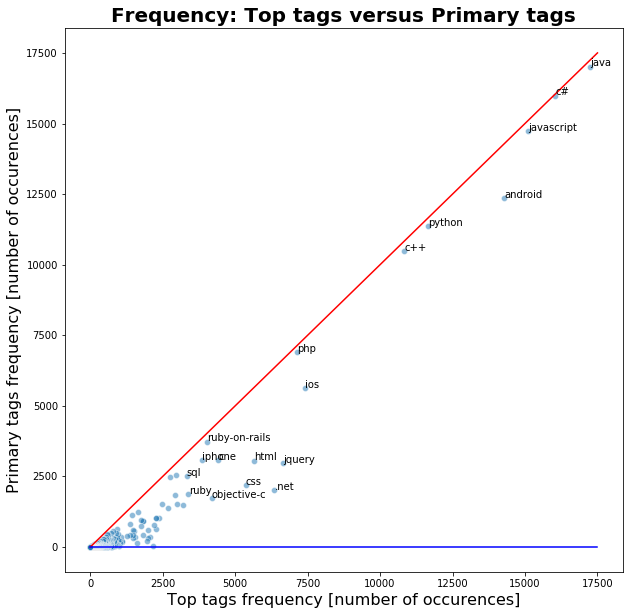

In [9]:
# Relation in-between frequency for top tags versus primary tags 
import numpy as np

# plot
plt.figure(figsize=(10, 10))
plt.title("Frequency: Top tags versus Primary tags", fontweight="bold", size = 20)
sns.scatterplot(x="freq_all", y="freq_primary", data=df, alpha=0.5)

# text annotations
for i in range(0,18):
    plt.annotate(df.loc[i,"tags"],
                 (df.loc[i,"freq_all"]+10, df.loc[i,"freq_primary"]+10),
                 size=10)

# unity line
u = np.linspace(0,17500,10)
plt.plot(u,u, c="red")
plt.plot(u,u*0, c="blue")
    
plt.xlabel("Top tags frequency [number of occurences]", size=16)
plt.ylabel("Primary tags frequency [number of occurences]", size=16)
plt.show()  

Tags relatively close to the red unity line are almost always primary tags, whereas the ones close to the blue line are almost never. Most commons tags are often primary and seems to correspond of popular programming languages.
For the rest we will focus the top 150 most commons tags.

In [10]:
# creaton of top tag list
top_n = 150
top_t = list(df.loc[0:top_n-1, "tags"])

# Extra infos
count_top = df.loc[0:top_n, "freq_all"].sum()
count_all = df["freq_all"].sum()
fract_t = round(top_n/len(df),2)*100
fract_v = round(count_top/count_all,3)*100
print("The top {} tags ({}% of the tag population)\
represent {}% in term of volume/occurences.".format(top_n, fract_t, fract_v))

The top 150 tags (1.0% of the tag population)represent 49.0% in term of volume/occurences.


### 1.2 Corpus processing
In this section we clean and explore the corpus (body columns).
We will extract nouns or adjectives that are not in a stopword list.

In [11]:
# Part of Speech Tagging
import nltk
from nltk.tokenize import PunktSentenceTokenizer   # already train sentence tokensier
from nltk.corpus import stopwords
import numpy as np

# --------------------------------------------------------------------------------

# standard stopwords list from nltk library
stopwords = set(stopwords.words("english"))

# updated with some specific words found in the corpus
stopwords.update(["p","/p","way","=","something", "anyone", "possible", "good", "example",
                 "question", "solution", "able", "different", "first", 'following',
                  "anything", 'help', 'thing','sure', 'many', 'lot', 'much', "several",
                  "wrong", "right", "idea", "easy", "everything", "difference", "|",
                 "certain", "kind", "great", "nothing", "answer", "please", "little",
                 "/", r"\&gt", "+", "..", "specific", "code", "new", "name",
                 "error", "use", "file", "work", "value", "ok", "true", "end"])

def process_content(text_body, stopwords):
    """
    Tokenize a text ('text_body') by words and keep the nouns(NN) and adjective or numeral, ordinal (JJ) 
    then remove stop words ('stopwords').
    Inputs:
        - text_body: string
        - stopwords: list of string
    Output:
        - return a list of words selection
        """
    
    tokenizer = PunktSentenceTokenizer()
    tokenized = tokenizer.tokenize(text_body)
    all_nouns = []   
    for sentence in tokenized:
        # words = nltk.word_tokenize(sentence)
        words = sentence.split()
        # get the information of the word (noune, verb,etc..)
        tagged = nltk.pos_tag(words)  
        for w in tagged:
            if ((w[1] == "NN")or(w[1] == "JJ")) and (w[0] not in stopwords):
                all_nouns.append(w[0])
    return all_nouns

In [12]:
# TEST #############

all_words = nltk.FreqDist()
for body in corpora.sample(1000):
    tokenized_body = process_content(body, stopwords)
    for w in tokenized_body:
        all_words[w] += 1 
        
print("{} words have been extracted".format(len(all_words)))

10407 words have been extracted


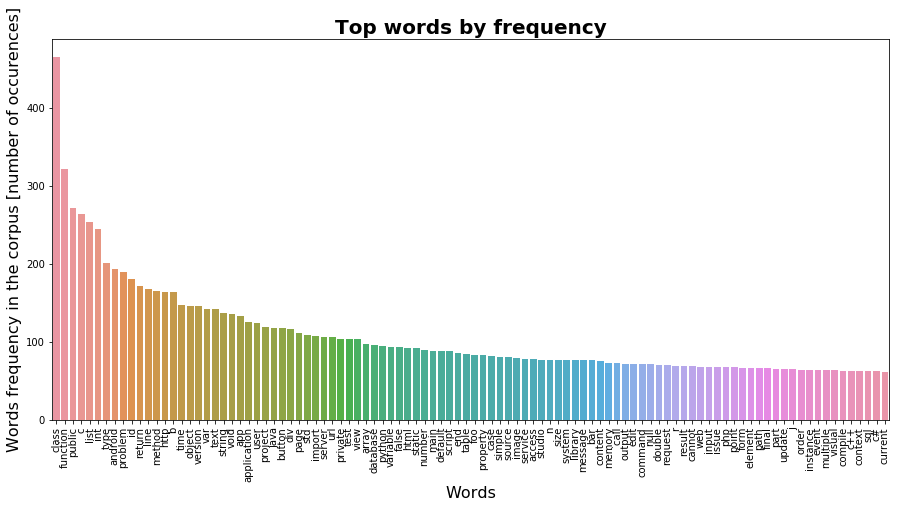

In [13]:
# most frequent words
# inputs
top_n = 100   # number of top words to display
df = pd.DataFrame(all_words.most_common(top_n), columns=["words","freq"])

# plot
plt.figure(figsize=(15,7))
plt.title("Top words by frequency", fontweight="bold", size=20)
plt.xticks(rotation=90, size=10)
sns.barplot(y="freq", x="words", data=df.loc[0:top_n, :], label="Total");
plt.xlabel("Words", size=16)
plt.ylabel("Words frequency in the corpus [number of occurences]", size=16)
plt.show()

### 1.3 Feature engineering
In this section, based on our corpus and list of most commons words, we will create new features that can be used as input for our models:
- TF Term Frequency table: for each documents (row) we will compute the frequency of the most frequent words (columns)
- TF-IDF Term Frequency - Inverse Document Frequency: The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. This help to reduce the importance of the very commons words. More information [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
First, to build those tables we need to select wich feature/words that would be used as input. For this we will run several times:
    1. Create vocabulary list
    2. Create TF and TF-IDF Tables (Bag of Words)
    3. Run the LDA and NMF models
    4. score evaluation

On each loops we will change the initial vocabulary list composition, and see the impact on the final scoring.

In [14]:
# vocabulary list creation
def vocabulary(all_words, all_tags, Nw, Nt):
    """ return a dictionary of vocabulary. It merges the top Nw words from all_words
    with the top Nt from all_tags. This format is needed as input of nltk vectoriser"""
    top_w = list(zip(*all_words.most_common(Nw)))[0]
    top_t = list(zip(*all_tags.most_common(Nt)))[0]
    # add top tags to this list
    top_w = set(list(top_w) + list(top_t))

    # formating: list of for for vectorized input
    return dict(zip(top_w, range(0, len(top_w))))

In [137]:
# Functions used for the scoring evaluations
# Note: The words return here are the top X based on the number of occurence
# could be better the have the top percentage compare to the complete Corpus

def display_topics2(model, feature_names, no_top_words=25):
    """create a panda data frame of the top words present in each topics.
    inputs: 
        - model: fitted model, from where we will extract the results (numeric)
        - feature_names: list of string (words used in the model)
        - no_top_words: int, the number of top words per topics we want to extract
    output:
        - DataFrame 
        """
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict["Topic%d" % (topic_idx)] = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(word_dict).T



def tag_pred(model, vectorized_input, feature_names, top_t, nb_tag_pred=10, threshold=0.15):
    """
        - threshold: topic frequency threshold to be considered as one of "mains" topics
        - nb_tag_pred: Number of proposed tag per document
    """
    
    # Topic df ----------------------------------------------------------------------------
    topic_df = display_topics2(model, feature_names, no_top_words=25)
    # associate each topic with a list of tags
    topics_kwords_df = (topic_df.isin(top_t)*topic_df).T
    topic2tags_d = {}
    tags_per_topic = []
    for topic in topics_kwords_df:
        tag_list = []
        for e in topics_kwords_df.loc[:, topic]:
            if e is not "":
                tag_list.append(e)
        topic2tags_d[topic] = tag_list

    # Create Document Vs Topic df ------------------------------------------------------
    model_output = model.transform(vectorized_input)
    topicnames = ["Topic" + str(i) for i in range(model.components_.shape[0])]
    docnames = ["Post" + str(i) for i in range(vectorized_input.shape[0])]
    df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

    # Tag predictions -------------------------------------------------------------------
    tag_pred = []
    for post in df_document_topic.index:
            tags_post = []
            topics_proba = df_document_topic.loc[post, :]
            mask = topics_proba >= threshold
            topic_pred = list(df_document_topic.loc[post, mask].index)
            tot_proba = topics_proba[topic_pred].sum()
            for topic in topic_pred:
                nb_elements = int(round(topics_proba[topic]*10/tot_proba,0))  # pic number of top elements ~ to proba of the topic
                tags_post = tags_post + topic2tags_d[topic][0:nb_tag_pred].copy()
            if len(topic_pred) == 0:  # if no major topic in this post, propose just top 10 tags
                tags_post = tags_post + top_t[0:nb_tag_pred].copy()
            tag_pred.append(tags_post)
    return tag_pred

def topic_score(model, vectorized_input, feature_names, top_t, document_tags, limited=True):
    """The scoring function is design for the purpose off assessing the quality of the predicted tag
    in the context of tags suggestion. For tis we will compute the ratio of real tags words present
    in the predicted list of tags.
    Inputs: 
        - model: fitted sklearn model, from where we will extract the results (numeric).
        - vectorized_input: tf or tf-idf vectorized input
        - feature_names: list of string (words used in the model)
        - document_tags: list of list of str, each document has a list of real tags
        - top_t: list of str, all existing tags 
        - limited: indicate if the scoring is done on tags present in the vocabulary list (False: or all tags).
        True by default since we cannot predic tags that are not in the input vocabulary list.
    Output:
        - tag_pred: list of list, proposed tags.
        """

    prediction = tag_pred(model, vectorized_input, feature_names, top_t)

    # Scoring ----------------------------------------------------------------------------------
    tag_score = []   # list of score for each document (score = ratio of real tags present in the prediction)
    for i in range(len(document_tags)):
        score = 0 
        count_e = 0
        for e in document_tags[i]: 
            if ((limited==True) and (e in vocab_list)) or (limited==False):
                if e in prediction[i]:
                    score = score + 1
                count_e = count_e + 1    
                tag_score.append(round(score/count_e,2))

    return sum(tag_score)/len(tag_score)

In [32]:
### TEST #####################################################
    # topic df ----------------------------------------------------------------------------
topic_df = display_topics2(lda_tfidf, feature_names, no_top_words=50)
    # associate each topic with a list of tags
topics_kwords_df = (topic_df.isin(top_t)*topic_df).T
topic2tags_d = {}
tags_per_topic = []
for topic in topics_kwords_df:
    tag_list = []
    for e in topics_kwords_df.loc[:, topic]:
        if e is not "":
            tag_list.append(e)
    topic2tags_d[topic] = tag_list[0:10]

In [161]:
topic_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Topic0,android,git,app,application,version,file,problem,http,xml,project,...,script,private,string,return,int,page,object,c,sql-server,linux
Topic1,test,method,end,asp.net,testing,class,application,object,problem,time,...,private,debugging,variable,unit-testing,int,c,rest,url,performance,text
Topic2,function,var,return,haskell,angularjs,type,javascript,script,id,object,...,view,version,ajax,application,line,c,testing,project,rest,templates
Topic3,button,xcode,angular,type,facebook,vim,app,ios,user,application,...,script,javascript,end,false,android,server,objective-c,cocoa,public,string
Topic4,exception,datetime,html5,typescript,type,method,object,string,application,time,...,page,debugging,c,private,security,static,url,import,html,script
Topic5,image,id,wpf,security,application,http,user,problem,type,file,...,array,void,android,database,java,ios,int,static,asp.net,xml
Topic6,view,time,iphone,qt,app,gcc,ios,application,problem,user,...,list,cocoa,windows,public,c++,objective-c,swift,performance,debugging,server
Topic7,div,html,css,ios,class,page,application,text,id,http,...,testing,var,static,angularjs,public,return,asp.net,templates,string,object
Topic8,server,python,sql,database,http,application,script,time,problem,file,...,mysql,text,id,url,c#,testing,b,oracle,rest,debugging
Topic9,line,object,var,perl,file,string,number,problem,return,end,...,app,java,windows,view,server,project,void,performance,image,rest


In [160]:
topics_kwords_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24
0,android,,function,,exception,image,,,,,...,http,list,,windows,,,file,,,php
1,git,,,xcode,datetime,,,html,python,,...,,,javascript,c++,database,,shell,c,c#,xml
2,,,,angular,html5,wpf,iphone,css,sql,,...,,,jquery,,.net,scala,,,maven,algorithm
3,,asp.net,haskell,,typescript,security,qt,ios,database,perl,...,json,,function,regex,linux,python,templates,java,svn,mysql
4,,testing,angularjs,facebook,,,,class,http,file,...,spring,cocoa,,objective-c,mysql,numpy,,,gradle,swift
5,file,class,,vim,,http,gcc,,,string,...,string,,ajax,,sql,file,,,file,
6,,,javascript,,,,ios,,,,...,,,,linux,oracle,class,,,,github
7,http,,,ios,string,,,,,,...,c++11,,,c,,symfony,linux,function,.net,file
8,xml,,,,,,,,,,...,,,arrays,file,,,c,c++,,
9,,,,,,file,,http,file,,...,class,,,,,,bash,class,java,


In [158]:
### TEST #############################
    # Create Document Vs Topic Matrix ------------------------------------------------------
model_output = lda_tfidf.transform(tfidf)
    # column names
topicnames = ["Topic" + str(i) for i in range(lda_tfidf.components_.shape[0])]
    # index names
docnames = ["Post" + str(i) for i in range(tfidf.shape[0])]
    # Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

In [127]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24
Post0,0.02,0.62,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
Post1,0.02,0.02,0.02,0.02,0.09,0.02,0.53,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
Post2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.68,0.01,0.01,0.01,0.01,0.01
Post3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.27,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.22,0.01,0.01,0.23
Post4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.29,0.01,0.01,0.01


In [146]:
df_document_topic.loc[:,:].values

array([[0.02, 0.62, 0.02, ..., 0.02, 0.02, 0.02],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.52, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.01, 0.01, 0.75, ..., 0.01, 0.01, 0.01],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02]])

(0, 30000)

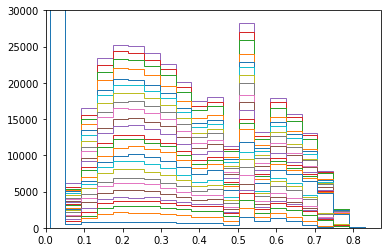

In [157]:
plt.hist(df_document_topic.loc[:,:].values, bins=20, histtype='step', stacked=True, fill=False)
# plt.yscale("log")
plt.xlim(0)
plt.ylim(0,30000)

In [113]:
###TEST########################
# Tag prediction -----------------------------------------------------------------------
treshold = 0.15
tag_pred = []
for post in df_document_topic.index:
        tags_post = []
        topics_proba = df_document_topic.loc[post, :]
        mask = topics_proba >= treshold
        topic_pred = list(df_document_topic.loc[post, mask].index)
        tot_proba = topics_proba[topic_pred].sum()
        for topic in topic_pred:
            nb_elements = int(round(topics_proba[topic]*10/tot_proba,0))  # pic number of top elements ~ to proba of the topic
            tags_post = tags_post + topic2tags_d[topic][0:nb_elements].copy()
        if len(topic_pred) == 0:  # if no major topic in this post, propose just top 10 tags
            tags_post = tags_post + top_t[0:10].copy()
        tag_pred.append(tags_post)

In [24]:
def raw2XY(text_df, tags_list, vocab_list):
    """format inputs to be ready to be use in sklearn models
    input X, y"""    

    # Y
    tag_vectorizer = CountVectorizer(vocabulary=tags_list,
                                token_pattern=r"(?<=<).+?(?=>)")  #  to keep c#, c++, .net, ...
    Y = tag_vectorizer.fit_transform(text_df.loc[:, "Tags"])
    Y = pd.DataFrame(Y.A, 
                     columns=tag_vectorizer.get_feature_names(),
                     index=text_df.index
                    )
      
    # X
    corpora = text_df.loc[:, "Title"] + text_df.loc[:, "Body"]
    corpus_vectorizer = CountVectorizer(vocabulary=vocab_list,
                                        token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]")  #  to keep c#, c++, .net, ...
    X = corpus_vectorizer.fit_transform(corpora.apply(cleantext))
    X = pd.DataFrame(X.A, 
                     columns=corpus_vectorizer.get_feature_names(),
                     index=text_df.index
                    )
    
    return X, Y

In [25]:
vocab_list = vocabulary(all_words, all_tags, 500, 150)

In [26]:
# from sklearn.feature_extraction.text import CountVectorizer
# X, Y = raw2XY(text, top_t, vocab)

In [27]:
import random

def strat_binary_multilabels(Y, min_occurences=200):
    """stratification sampling on one-hot encoded features
    Inputs: 
        - Y: One hot encoded DataFrame
        - min_occurence: minimum occurence of each features
    Ouputs:
        - a list of index that can be used to sample
        """
    # df initialisation
    Y_strat = Y.iloc[0:100,:]
    Y_temp = Y.iloc[100:,:]

    # iteration through each features
    for var_name in reversed(Y_temp.columns):  # reversed to start from less present tags
        # print(var_name)
        mask = Y_temp.loc[:,var_name] == 1
        idx = Y_temp.loc[mask, :].index

        n_in = Y_strat.loc[:,var_name].sum()
        idx_sel = random.sample(list(idx), max(0,(min_occurences-n_in)))

        Y_strat = pd.concat([Y_strat, Y_temp.loc[idx_sel,:]])
        Y_temp = Y_temp.drop(idx_sel)     
    return Y_strat.index

In [28]:
idx = strat_binary_multilabels(Y,200)

In [34]:
corpora_save = corpora
corpora = corpora.loc[idx]

In [162]:
# lists of tags update  ## to remove in the first place
document_tags =  [] # "list of list" of tags for each document
for line in tags[idx]:
    tag = line.split()
    document_tags.append(tag)

NameError: name 'idx' is not defined

In [65]:
# Manual grid seach on the composition of vocabulary

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import numpy as np

n_top_w = [1,100,500]
n_top_t = [100,150,200]

grid_score_lda_tf = pd.DataFrame(0, index = n_top_w, columns= n_top_t) 
grid_score_lda_tf.index.name = "n_top_w"
grid_score_lda_tf.columns.name = "n_top_t"
grid_score_lda_tfidf = grid_score_lda_tf.copy()
grid_score_nmf_tf = grid_score_lda_tf.copy()
grid_score_tfidf = grid_score_lda_tf.copy()
grid_score_nmt_tfidf = grid_score_lda_tf.copy()

for w in n_top_w:
    for t in n_top_t:

        voca = vocabulary(all_words, all_tags, w, t)
        # Vectorizer ------------------------------------------
        # tf
        tf_vectorizer = CountVectorizer(vocabulary=voca,
                                        stop_words=stopwords)
        tf = tf_vectorizer.fit_transform(corpora)

        # tf-idf
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(vocabulary=voca,
                                           stop_words=stopwords)
        tfidf = tfidf_vectorizer.fit_transform(corpora)

        # extraction of feature names
        feature_names = tf_vectorizer.get_feature_names()     
        
        
        # Models ------------------------------------------------
        no_topics = 25 
        # Run LDA on tf
        lda_tf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tf)
        grid_score_lda_tf.loc[w, t ] = topic_score(lda_tf, 
                                                   tf, 
                                                   feature_names, 
                                                   top_t, 
                                                   document_tags)

        # Run LDA on tfidf
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                            random_state=1).fit(tfidf)
        grid_score_lda_tfidf.loc[w, t ] = topic_score(lda_tfidf, 
                                                      tfidf, 
                                                      feature_names, 
                                                      top_t, 
                                                      document_tags)
        
        # Run NMF on tf
        nmf_tf = NMF(n_components=no_topics, 
                     random_state=1, 
                     init='nndsvd').fit(tf)
        grid_score_nmf_tf.loc[w, t ] = topic_score(nmf_tf, 
                                                   tf, 
                                                   feature_names,
                                                   top_t, 
                                                   document_tags)
        
        # Run NMF on tfidf
        nmf_tfidf = NMF(n_components=no_topics, 
                        random_state=1, 
                        init='nndsvd').fit(tfidf)
        grid_score_nmt_tfidf.loc[w, t ] = topic_score(nmf_tfidf, 
                                                      tfidf, 
                                                      feature_names, 
                                                      top_t, 
                                                      document_tags)

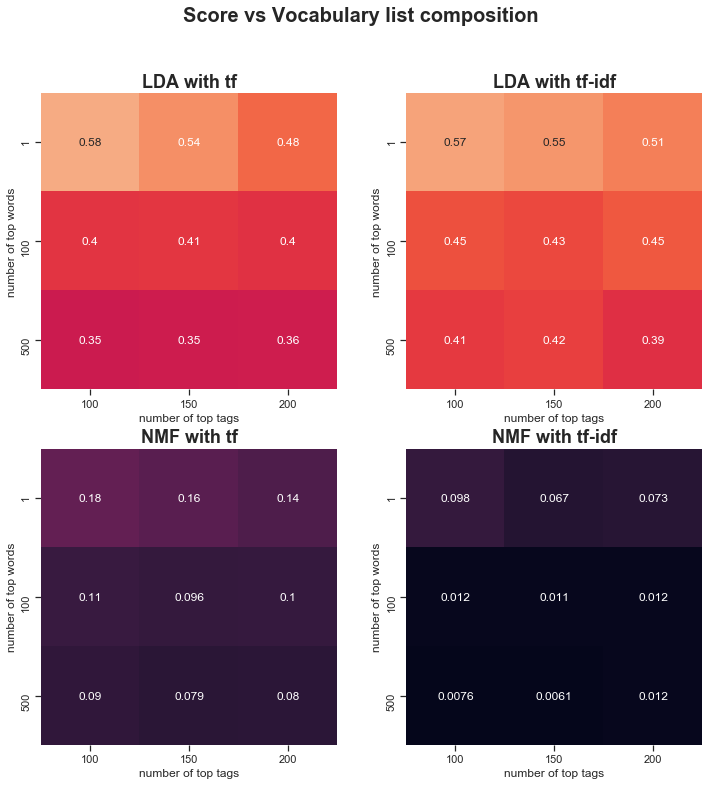

In [88]:
# plot results

# inputs
grid_scores = [grid_score_lda_tf, grid_score_lda_tfidf, grid_score_nmf_tf, grid_score_nmt_tfidf]
titles = ["LDA with tf", "LDA with tf-idf", "NMF with tf", "NMF with tf-idf"]

# plot
sns.set(style="ticks", palette="pastel")
fig = plt.figure(figsize=(12,12))
fig.suptitle("Score vs Vocabulary list composition", fontweight="bold", size=20)
for i,grid_score in enumerate(grid_scores):
    plt.subplot(2,2,i+1) 
    sns.heatmap(grid_score.values, 
                square=True, 
                annot=True, 
                cbar=False,
                vmin=0.0,
                vmax=0.7,
                xticklabels=n_top_t,
                yticklabels=n_top_w)
    plt.title(titles[i], fontweight="bold",size = 18)
    plt.xlabel('number of top tags')
    plt.ylabel('number of top words');

**Vocabulary composition:**  
The best score is obtain when the vocabulary input list is a combinaison of the top 1 words and the top 150 tags. It is quite instinctive that the chance of getting a correct tags is better if we select only the tags words as feature. We somehow semi-supervise the model by doing so.  
  
   
**Models:**  
In term of model, Latent Dirichlet Allocation (LDA) perform better here than Non-Negative Matrix Factorization (NMF). Note that we did not go into any parameter optimisation at this stage.
LDA with tf-idf perform similar than LDA with tf when the vocabulary list is only composed by tags. However,LDA with tf score degrade faster when adding some top words (that are not tags) . This also make sense: the tf-idf tend to minimize the effect of "common/general words" present on all documents. This is relevant only when "common/general words" are present in the vocabulary list.
  
**Conclusion:**  
However here, we might also want the futur tag recommendation engine to be able to also produce new tags (IT world is changing fast). So even if it degrade a little bit our final quality we would introduce the 50 top words from the corpus.

In [138]:
# LDA TF-idf with previous choices
no_topics = 25
voca = vocabulary(all_words, all_tags, 50, 100)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=voca,
                                   token_pattern=r"[a-zA-Z.0-9+#-_/]*[^.\s]",  #  to keep c#, c++, .net, ...
                                   stop_words=None)
tfidf = tfidf_vectorizer.fit_transform(corpora)

# extraction of feature names
feature_names = tfidf_vectorizer.get_feature_names()  

# Run LDA on tfidf
lda_tfidf = LatentDirichletAllocation(n_components=no_topics, 
                                random_state=0).fit(tfidf)

# print some metrics
data_dense = tfidf.todense()   # to compute sparsity (Percentage of Non-Zero cells)
print("LDA with tfidf---------------------------------------------------------")
score = topic_score(lda_tfidf, tfidf, feature_names, top_t, document_tags)
print("Tags prediction hit rate:", round(score*100,1), "%")
sparsicity = ((data_dense > 0).sum()/data_dense.size)*100
print("Sparsicity:              ", round(sparsicity,1), "%")
print("Log Likelihood:          ", round(lda_tfidf.score(tfidf),0))
print("Perplexity:              ", round(lda_tfidf.perplexity(tfidf),0))

# top 10 words in each topics
display_topics2(lda_tfidf, feature_names, no_top_words=10)

LDA with tfidf---------------------------------------------------------
Tags prediction hit rate: 58.9 %
Sparsicity:               3.4 %
Log Likelihood:           -1902152.0
Perplexity:               335.0


,0,1,2,3,4,5,6,7,8,9
Topic0,android,git,app,application,version,file,problem,http,xml,project
Topic1,test,method,end,asp.net,testing,class,application,object,problem,time
Topic2,function,var,return,haskell,angularjs,type,javascript,script,id,object
Topic3,button,xcode,angular,type,facebook,vim,app,ios,user,application
Topic4,exception,datetime,html5,typescript,type,method,object,string,application,time
Topic5,image,id,wpf,security,application,http,user,problem,type,file
Topic6,view,time,iphone,qt,app,gcc,ios,application,problem,user
Topic7,div,html,css,ios,class,page,application,text,id,http
Topic8,server,python,sql,database,http,application,script,time,problem,file
Topic9,line,object,var,perl,file,string,number,problem,return,end


## 3.LDA: LatentDirichletAllocation

In [139]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
10     -20.448109  163.728455       1        1  8.650211
22      51.951988  207.675507       2        1  6.028247
2       76.739754   10.893189       3        1  4.829348
17    -112.801430  130.427963       4        1  4.691122
15    -103.086151   50.793953       5        1  4.544243
7     -155.883133  -12.194027       6        1  4.372752
1      -40.390247   94.478676       7        1  4.200222
19      -7.544534   31.685301       8        1  4.157146
11      45.708961   96.232811       9        1  4.076320
14     -26.514854  252.084915      10        1  3.923728
0       98.608551  -74.203270      11        1  3.913452
21    -120.854591 -101.256630      12        1  3.666214
8      -42.181755  -93.632019      13        1  3.645177
23    -182.348343   78.186317      14        1  3.628202
3      115.002022  149.183548      15        1  3.456017
24     -62.322487 -188.165070      16        1  3.437964
6      -73.231407  -18.483276      17        1  3.425322
20     144.752731   58.471390      18        1  3.397093
9     -199.905975  165.314484      19        1  3.368893
18    -107.931702  296.205536      20        1  3.368188
16    -242.983093   17.362951      21        1  3.352415
5     -106.667290  206.343826      22        1  3.266385
12      30.175735 -142.035294      23        1  3.128256
13    -205.532135  -90.374939      24        1  2.890317
4       13.695492  -40.693836      25        1  2.582768, topic_info=     Category          Freq              Term         Total  loglift  logprob
term                                                                         
2     Default   6272.000000           android   6272.000000  30.0000  30.0000
104   Default  10960.000000              file  10960.000000  29.0000  29.0000
138   Default   5726.000000              list   5726.000000  28.0000  28.0000
130   Default   8791.000000          function   8791.000000  27.0000  27.0000
29    Default   3973.000000             image   3973.000000  26.0000  26.0000
112   Default   7841.000000            string   7841.000000  25.0000  25.0000
4     Default   4333.000000            python   4333.000000  24.0000  24.0000
11    Default   3781.000000             table   3781.000000  23.0000  23.0000
60    Default   3489.000000         exception   3489.000000  22.0000  22.0000
116   Default   3201.000000               php   3201.000000  21.0000  21.0000
76    Default   6130.000000              user   6130.000000  20.0000  20.0000
57    Default   4177.000000              view   4177.000000  19.0000  19.0000
34    Default   5124.000000              line   5124.000000  18.0000  18.0000
106   Default   5164.000000           project   5164.000000  17.0000  17.0000
69    Default   3384.000000            import   3384.000000  16.0000  16.0000
97    Default   5237.000000            server   5237.000000  15.0000  15.0000
100   Default   3548.000000           windows   3548.000000  14.0000  14.0000
90    Default   6122.000000               app   6122.000000  13.0000  13.0000
5     Default   4703.000000              text   4703.000000  12.0000  12.0000
124   Default   2411.000000               git   2411.000000  11.0000  11.0000
43    Default   3500.000000             false   3500.000000  10.0000  10.0000
47    Default   4988.000000            public   4988.000000   9.0000   9.0000
1     Default   2891.000000            button   2891.000000   8.0000   8.0000
3     Default   4579.000000               var   4579.000000   7.0000   7.0000
46    Default   5135.000000               int   5135.000000   6.0000   6.0000
31    Default   2923.000000               div   2923.000000   5.0000   5.0000
58    Default   3022.000000          variable   3022.000000   4.0000   4.0000
44    Default   2965.000000                c#   2965.000000   3.0000   3.0000
75    Default   2595.000000               c++   2595.000000   2.0000   2.0000


Topics are well clusterised with very similar size. But we can see that some topics are stil merge as Java and xml, Ubuntu and dokers.

In [99]:
# Manual Grid search, using our "tag hit rate" as scoring metric.

# values to test
topic_word_p = [0, 0.1, 0.25]  # for topic_word_prior parameter
doc_topic_p = [0, 0.1, 0.25]   # for doc_topic_prior parameter

# scoring empty dataFrame
grid_score = pd.DataFrame(0, index = topic_word_p, columns= doc_topic_p) 
grid_score.index.name = "topic_word_prior"
grid_score.columns.name = "doc_topic_prior"

# run the scoring calculation
for a in topic_word_p:
    for l1 in doc_topic_p:
        lda_tfidf = LatentDirichletAllocation(n_topics=no_topics, 
                                    topic_word_prior=a,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=l1,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t, document_tags)

In [94]:
grid_score

doc_topic_prior,0.0,0.1,0.25
topic_word_prior,,,
0.00,0.614901,0.451397,0.025855
0.10,0.626103,0.428943,0.029664
0.25,0.622559,0.452382,0.030700


In [104]:
# Let's run on n_components and learning_decay
n_components = [20, 25, 30] 
learning_decay = [0.5, 0.7, 0.9]

grid_score = pd.DataFrame(0, index=n_components, columns=learning_decay) 
grid_score.index.name = "n_components"
grid_score.columns.name = "learning_decay"

for a in n_components:
    for l1 in learning_decay:
        lda_tfidf = LatentDirichletAllocation(n_components=a,
                                        learning_decay=l1,
                                        topic_word_prior=0.1,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                        doc_topic_prior=0.0,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                        max_iter=50, 
                                        learning_method='online', 
                                        learning_offset=50.,
                                        random_state=0).fit(tfidf)
        grid_score.loc[a, l1] = topic_score(lda_tfidf, tfidf, feature_names, top_t, document_tags)

In [105]:
grid_score

learning_decay,0.5,0.7,0.9
n_components,,,
20,0.586421,0.624926,0.580664
25,0.595416,0.626103,0.635473
30,0.632325,0.609753,0.628719


In [140]:
# Final Model

lda_tfidf = LatentDirichletAllocation(n_components=25,
                                    learning_decay=0.9,
                                    topic_word_prior=0.1,   # high beta-value means that each topic is likely to contain a mixture of most of the words
                                    doc_topic_prior=0.0005,  # high alpha-value means that each document is likely to contain a mixture of most of the topic
                                    max_iter=50, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(tfidf)

In [141]:
topic_score(lda_tfidf, tfidf, feature_names, top_t, document_tags)

0.5873180264443423

In [116]:
# plot with PyLDAvis library
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
11    -110.734604   -3.943753       1        1  11.014182
18    -104.667732  -53.844856       2        1   8.002914
6      -85.436264   91.523491       3        1   5.930653
21      65.234459   -9.661510       4        1   5.771667
20      16.241478   16.411741       5        1   5.528051
0      -62.587536  -80.564224       6        1   5.273958
7       -0.393248  115.499176       7        1   5.080267
12     -40.974251   78.278114       8        1   4.731346
1       63.204338   41.127274       9        1   4.319722
24      42.248791   86.052429      10        1   4.299193
9      -66.875549  -14.002359      11        1   4.284239
13    -194.681351  108.444099      12        1   4.212650
5     -120.706543   58.706562      13        1   3.965130
14     -56.335785  129.548203      14        1   3.894674
22      50.850632  161.911819      15        1   3.891304
15     -54.233105 -164.899826      16        1   3.176397
23      42.097115  -70.874519      17        1   2.940388
10     -14.849505  -74.313347      18        1   2.781016
16    -153.270309   17.937889      19        1   2.116452
17      15.764278  -29.825584      20        1   1.918121
2       -0.486045   57.248302      21        1   1.865784
3      -34.020973   25.335039      22        1   1.377388
8       34.058418 -156.703217      23        1   1.238829
4      -72.642494   37.930733      24        1   1.202570
19     -25.261736  -19.336317      25        1   1.183104, topic_info=     Category         Freq               Term        Total  loglift  logprob
term                                                                        
6     Default  1115.000000              class  1115.000000  30.0000  30.0000
17    Default   598.000000               user   598.000000  29.0000  29.0000
0     Default   502.000000            android   502.000000  28.0000  28.0000
25    Default   381.000000             number   381.000000  27.0000  27.0000
94    Default   328.000000             result   328.000000  26.0000  26.0000
122   Default   399.000000              image   399.000000  25.0000  25.0000
49    Default   379.000000                  b   379.000000  24.0000  24.0000
8     Default   588.000000                int   588.000000  23.0000  23.0000
66    Default   615.000000               list   615.000000  22.0000  22.0000
38    Default   477.000000                  c   477.000000  21.0000  21.0000
73    Default   303.000000            message   303.000000  20.0000  20.0000
109   Default   441.000000             python   441.000000  19.0000  19.0000
111   Default  1117.000000               file  1117.000000  18.0000  18.0000
97    Default   228.000000                c++   228.000000  17.0000  17.0000
36    Default   220.000000                ios   220.000000  16.0000  16.0000
121   Default   893.000000           function   893.000000  15.0000  15.0000
37    Default   346.000000               null   346.000000  14.0000  14.0000
5     Default   202.000000                git   202.000000  13.0000  13.0000
45    Default   426.000000                var   426.000000  12.0000  12.0000
44    Default   554.000000                app   554.000000  11.0000  11.0000
60    Default   524.000000               line   524.000000  10.0000  10.0000
89    Default   346.000000            windows   346.000000   9.0000   9.0000
116   Default   405.000000             import   405.000000   8.0000   8.0000
2     Default   358.000000               case   358.000000   7.0000   7.0000
102   Default   441.000000               java   441.000000   6.0000   6.0000
88    Default   629.000000             public   629.000000   5.0000   5.0000
15    Default   317.000000                sql   317.000000   4.0000   4.0000
35    Default   399.000000              array   399.000000   3.0000   3.0000
131   Default   146.000000               perl   146.000000   2.0000   2.0000
136 

## 5. supervised models
In this section we will used the Tags information on 4 supervised classification models:
- LinearSVC
- Random Forest
- NaiveBase Gaussian  
- Logistic Regression


Since we can have more than one tags per documents, we need to handle a multilabels classification.   
Tags will be [One hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) in a DataFrame "Y".  
The labels input format would be a dataframe where each columns correspond to a tag, each row to a document. Value would be "1" if the tag is present for this document and "0" otherwise. 
We will continue to use the same words and tag list used for the unserpervised learning.


In [49]:
X, Y = raw2XY(text_df, top_t, vocab_list)
idx = strat_binary_multilabels(Y, min_occurences=200)
idx_train = text_df.drop(idx).index  # reverse selection
idx_train = strat_binary_multilabels(Y.loc[idx_train, :], min_occurences=200)

In [53]:
# top_w = list(zip(*all_words.most_common(500)))[0]
# top_t = list(zip(*all_tagss.most_common(150)))[0]
# vocab = set(list(top_w) + list(top_t))



In [138]:
idx_train_sub = strat_binary_multilabels(Y_train, min_occurences=200)
X_train = X_train.loc[idx_train,:]
Y_train = Y_train.loc[idx_train,:]

In [54]:
###SAVE POINT ########
with open('idx.txt', 'w') as f:
    for item in idx:
        f.write("%s\n" % item)

with open('idx_train.txt', 'w') as f:
    for item in idx_train:
        f.write("%s\n" % item)

In [25]:
vocab_list = vocabulary(all_words, all_tags, 1, 150)

X_test.shape: (19241, 150)
Y_test.shape: (19241, 150)
X_train.shape: (19543, 150)
Y_train.shape: (19543, 150)


In [59]:
# test different classifier with Multioutput 
# Note: unless random Forest all with standard parameters 

from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# rf
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=50, max_depth=10)).fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)

# GaussianNB
gaussNB = MultiOutputClassifier(GaussianNB()).fit(X_train, Y_train)
Y_pred_gauss = gaussNB.predict(X_test)

# SVC
svc = MultiOutputClassifier(LinearSVC()).fit(X_train, Y_train)
Y_pred_svc = svc.predict(X_test)

# Logistic regression
logi_reg = MultiOutputClassifier(LogisticRegression()).fit(X_train, Y_train)
Y_pred_logi_reg = logi_reg.predict(X_test)

In [60]:
logi_reg.score(X_test, Y_test)

0.14484694142716076

In [61]:
rf.score(X_test, Y_test)

0.08913258146665974

0.8643001922976976

In [ ]:
proba_Gauss = gaussNB.predict_proba(X_test)

In [64]:
# results DataFrame
results = pd.DataFrame(Y_test.sum(), 
                       index=Y_test.sum().index, 
                       columns=["occurence_test"])

# Hit Rate
results["Rf_hit_rate"] = (Y_pred_rf*Y_test).sum()/Y_test.sum(axis=0)
results["Gauss_hit_rate"] = (Y_pred_gauss*Y_test).sum()/Y_test.sum(axis=0)
results["svc_hit_rate"] = (Y_pred_svc*Y_test).sum()/Y_test.sum(axis=0)
results["logiReg_hit_rate"] = (Y_pred_logi_reg*Y_test).sum()/Y_test.sum(axis=0)
results["occurence_train"] = Y_train.sum()
results["range"] = results["occurence_train"].apply(lambda x : int(round(x/25,0)*25))

In [122]:
results.head()

,occurence_test,Rf_hit_rate,Gauss_hit_rate,svc_hit_rate,logiReg_hit_rate,occurence_train,range
java,1675,0.160597,0.966567,0.422687,0.493731,1770,1775
c#,1689,0.307282,0.970989,0.374778,0.380107,1755,1750
javascript,1096,0.052007,0.968978,0.272810,0.295620,1139,1150
android,957,0.781609,0.964472,0.599791,0.646813,1022,1025
python,1442,0.282247,0.974341,0.547157,0.665742,1445,1450


In [ ]:
i=1
a = (results["Rf_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()
print("{:30} {:30}%".format(titles[i]+":", round(a*100,2)))

Hit rate per model:
-------------------
Random Forest:            17.2%
Gaussian Naive Bayes:     93.0%
Support Vector Machine:   32.0%
Logistic regression:      33.5%


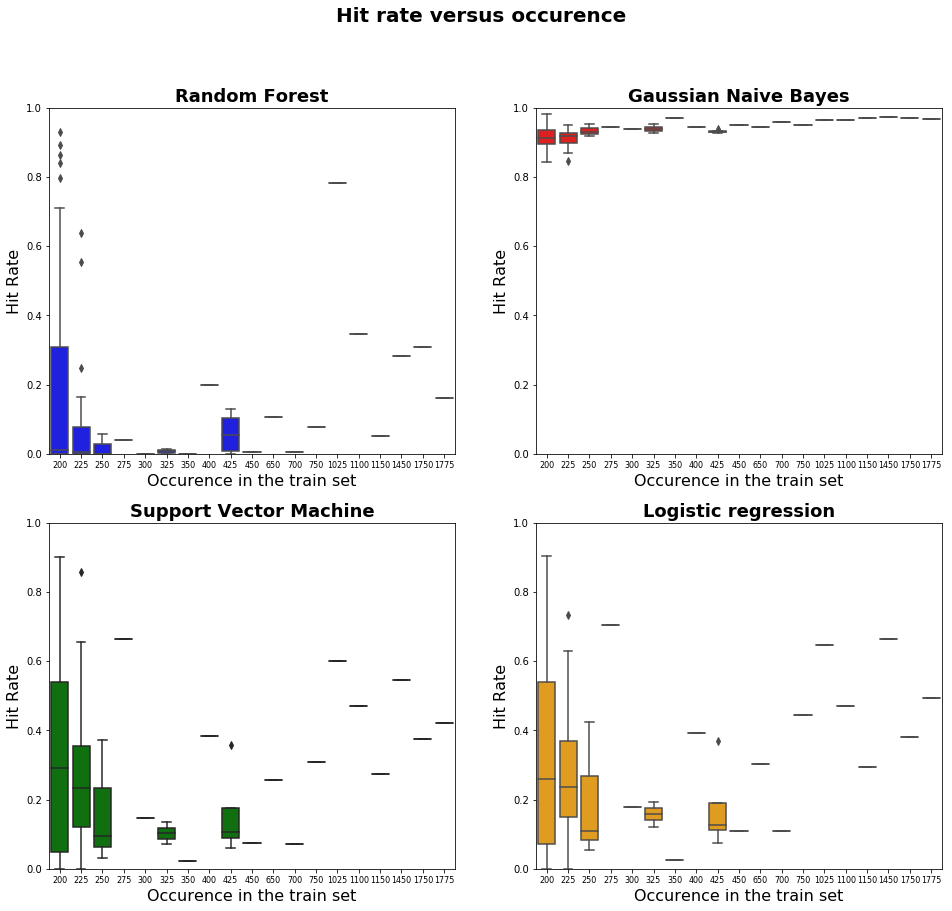

In [65]:
import seaborn as sns

col_label = ["Rf_hit_rate", "Gauss_hit_rate", "svc_hit_rate", "logiReg_hit_rate"]
colors = ["blue", "red", "green", "orange"]
titles = ["Random Forest", "Gaussian Naive Bayes", "Support Vector Machine", "Logistic regression"]

print("Hit rate per model:")
print("-------------------")
for i,m in enumerate(col_label):
    a = (results[m]*results["occurence_test"]).sum()/results["occurence_test"].sum()
    print("{:25} {:3.1f}%".format(titles[i]+":", a*100))

fig = plt.figure(figsize=(16,14))
fig.suptitle("Hit rate versus occurence", fontweight="bold", size=20)
for i,m in enumerate(col_label):
    plt.subplot(2,2,i+1) 
    sns.boxplot(x="range",
                y=m,
                data=results,
                color=colors[i])
    plt.title(titles[i],fontweight="bold", size=18)
    plt.ylim(0,1)
    plt.ylabel("Hit Rate", size=16)
    plt.xlabel("Occurence in the train set", size=16)
    plt.xticks(fontsize=8, rotation=0)
plt.show()

In [127]:
# average number of pred tag
Ys = [Y_pred_rf, Y_pred_gauss, Y_pred_svc, Y_pred_logi_reg]

print("Average number of predicted tags per model:")
for i,m in enumerate(col_label):
    print("{:25} {:3.1f}".format(titles[i]+":", Ys[i].sum(axis=1).mean()))

Average number of predicted tags per model:
Random Forest:            0.4
Gaussian Naive Bayes:     74.3
Support Vector Machine:   0.9
Logistic regression:      0.9


In [102]:
#### TEST Use proba #####################################
proba_rf = rf.predict_proba(X_test)
proba_rf_df = pd.DataFrame(0, 
                       index=Y_test.index, 
                       columns=Y_test.columns)
for i, c in enumerate(proba_rf_df.columns):
    print(i,c)
    proba_rf_df.loc[:,c] = list(zip(*proba_rf[i]))[1]

0 java
1 c#
2 javascript
3 android
4 python
5 c++
6 ios
7 php
8 jquery
9 .net
10 html
11 css
12 c
13 objective-c
14 ruby-on-rails
15 iphone
16 ruby
17 sql
18 angularjs
19 asp.net
20 git
21 mysql
22 r
23 node.js
24 linux
25 asp.net-mvc
26 django
27 sql-server
28 xcode
29 eclipse
30 c++11
31 arrays
32 performance
33 swift
34 string
35 json
36 windows
37 wpf
38 algorithm
39 visual-studio
40 scala
41 multithreading
42 html5
43 regex
44 macos
45 unit-testing
46 spring
47 haskell
48 database
49 bash
50 xml
51 ajax
52 twitter-bootstrap
53 postgresql
54 ruby-on-rails-3
55 debugging
56 google-chrome
57 css3
58 entity-framework
59 mongodb
60 cocoa-touch
61 http
62 vim
63 list
64 linq
65 angular
66 gcc
67 image
68 shell
69 generics
70 maven
71 android-studio
72 winforms
73 rest
74 security
75 visual-studio-2010
76 templates
77 svn
78 reactjs
79 numpy
80 datetime
81 oop
82 perl
83 intellij-idea
84 java-8
85 exception
86 hibernate
87 tsql
88 oracle
89 gradle
90 qt
91 cocoa
92 facebook
93 github
94 

In [128]:
proba_rf_df.head()

,java,c#,javascript,android,python,c++,ios,php,jquery,.net,...,user-interface,reflection,matplotlib,authentication,sorting,language-agnostic,design-patterns,visual-studio-2012,memory,asynchronous
Id,,,,,,,,,,,,,,,,,,,,,
9847880,0.043869,0.192820,0.038722,0.027002,0.036043,0.022742,0.020748,0.016841,0.008039,0.063016,...,0.009526,0.004348,0.005466,0.009033,0.005293,0.007216,0.007320,0.018625,0.004842,0.011746
9077101,0.048754,0.050386,0.076475,0.020650,0.041932,0.028042,0.111950,0.017874,0.028181,0.021931,...,0.012625,0.004772,0.005594,0.021269,0.007744,0.010352,0.007443,0.009569,0.004798,0.006332
27348604,0.048754,0.052359,0.029998,0.020650,0.042971,0.028042,0.021485,0.018571,0.006494,0.022498,...,0.010077,0.004772,0.005594,0.004550,0.006943,0.010581,0.009002,0.009569,0.004521,0.006332
9081841,0.040015,0.041686,0.079384,0.014962,0.028158,0.040313,0.013517,0.384484,0.011892,0.016142,...,0.007207,0.002293,0.003094,0.004737,0.005382,0.005842,0.006689,0.015486,0.004252,0.005700
9081846,0.048754,0.050459,0.029793,0.018756,0.044155,0.026039,0.018837,0.020544,0.005696,0.021440,...,0.007908,0.003150,0.003746,0.004024,0.005012,0.007496,0.006498,0.012866,0.004311,0.006005


In [110]:
### Y_pred_proba_rf: Mind very long calc: more than 10min
Y_pred_proba_rf = pd.DataFrame(0, 
                       index=Y_test.index, 
                       columns=Y_test.columns)

for idx in proba_rf_df.index:
    col = proba_rf_df.loc[idx, :].nlargest(10).index
    Y_pred_proba_rf.loc[idx, col] = 1

In [114]:
Y_pred_proba_rf.sum(axis=1).mean()

10.0

In [121]:
# score: hit rate
(Y_pred_proba_rf*Y_test).sum().sum()/Y_test.sum().sum()

0.743038157641164

Without parameter's tuning the Gaussian Naive Bayes is the model that give the best hit rate on tags. In the graph we can also see that its hit rate seems to continualy increase with the number of tags occurences in the train data set. tag with more than 200 occurene in the training reach a hit rate of at least 80%.

In [ ]:
(results["Rf_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

In [ ]:
(results["Gauss_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

In [ ]:
(results["svc_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

In [ ]:
(results["logiReg_hit_rate"]*results["occurence"]).sum()/results["occurence"].sum()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

SVC = OneVsRestClassifier(LinearSVC(), n_jobs=-1)

categories = list(Y_test.columns)
accuracy_score_d = {}
f1_score_d = {}
Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
for category in categories:
    # train
    SVC.fit(X_train, Y_train[category])
    
    # compute the testing accuracy
    Y_pred[category] = SVC.predict(X_test)
    accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
    f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])

In [ ]:
Y_test.index

In [ ]:
accuracy_score_d

In [ ]:
f1_score_d

In [ ]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
round(f1_score_tot, 3)

In [ ]:
Y_pred.sum(axis=0)

In [ ]:
Y_test.sum().index

In [ ]:
### Random Forest
#### TEST form https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff ###
# using binary relevance

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(RandomForestClassifier(n_estimators=50))
# train
classifier.fit(X_train, Y_train)
# predict
Y_pred = classifier.predict(X_test)
# tag hit rate
tag_hit_rate = (Y_test*Y_pred.A).sum().sum()/Y_test.sum().sum()
print("tag hit rate: ", round(tag_hit_rate*100,1), "%")

In [ ]:
results["logiReg_hit_rate"] = (Y_pred_logi_reg*Y_test).sum()/Y_test.sum(axis=0)

In [ ]:
### GaussianNB Using sklearn MultiOutputClassifier
#### TEST form https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff ###
# using binary relevance

# from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = MultiOutputClassifier(GaussianNB())
# train
classifier.fit(X_train, Y_train)
# predict
Y_pred = classifier.predict(X_test)
# tag hit rate
tag_hit_rate = (Y_test*Y_pred).sum().sum()/Y_pred.sum().sum()
print("tag hit rate: ", round(tag_hit_rate*100,1), "%")

In [ ]:
### GaussianNB Using sklearn MultiOutputClassifier
#### TEST form https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff ###
# using binary relevance
# from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression


# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = MultiOutputClassifier(LogisticRegression())
# train
classifier.fit(X_train, Y_train)
# predict
Y_pred = classifier.predict(X_test)
# tag hit rate
tag_hit_rate = (Y_test*Y_pred).sum().sum()/Y_pred.sum().sum()
print("tag hit rate: ", round(tag_hit_rate*100,1), "%")

In [ ]:
(Y_test*predictions.A).sum().sum()/predictions.A.sum().sum()

In [ ]:
####################################### TEST ###########################################

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def multilabel_model_fit(model, X_train, Y_train, X_test, Y_test):
    """run a model with a multilabel Y (matrix)
    Inputs:
        - model: an instance of a classification model
        - X_train, X_test: regular array
        - Y_train, Y_test: one hot encoded array, where each col is a label
    Outputs:
        - Y_pred: predicted one hot encoded array, where each col is a label
        - """
    categories = list(Y_test.columns)
    accuracy_score_d = {}
    f1_score_d = {}
    Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
    model_multi = {}
    for category in categories:
        # train
        model_multi[category] = model.fit(X_train, Y_train[category])

        # compute the testing accuracy
        Y_pred[category] = model.predict(X_test)
        accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
        f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])

    f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
    f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
    print("Overall f1_score:", round(f1_score_tot, 3))
    print("Tag hit rate:", round((Y_pred*Y_test).sum().sum()/Y_pred.sum().sum(), 3))    
    
def multilabel_model_pred(model, X):
    
    
def multilabel_scores(Y_pred, Y_test):    

In [ ]:
####################################### TEST ###########################################

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

model = KNeighborsClassifier()

categories = list(Y_test.columns)
accuracy_score_d = {}
f1_score_d = {}
Y_pred = pd.DataFrame(0, index=Y_test.index, columns=Y_test.columns)
for category in categories:
    # train
    model.fit(X_train, Y_train[category])
    
    # compute the testing accuracy
    Y_pred[category] = model.predict(X_test)
    accuracy_score_d[category] = accuracy_score(Y_test[category], Y_pred[category])
    f1_score_d[category] = f1_score(Y_test[category], Y_pred[category])
    
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
print("Overall f1_score:", round(f1_score_tot, 3))
print("Tag hit rate:", round((Y_pred*Y_test).sum().sum()/Y_pred.sum().sum(), 3))  

In [ ]:
# aggregation of f1-score (frequency ponderation)
f1_score_df=pd.DataFrame.from_dict(f1_score_d, orient='index')
f1_score_tot = (Y_test.sum()*f1_score_df.loc[:,0]).sum()/Y_test.sum().sum()
round(f1_score_tot, 3)

In [ ]:
(Y_pred*Y_test).sum().sum()/Y_pred.sum().sum()

In [ ]:
doc_num = 10

mask = Y_test.iloc[doc_num] == 1
print("doc number: ", doc_num, "----------------------------" )
print(X_test.iloc[doc_num])
print("")
print("Real tags from raw : ", tags.iloc[doc_num])
print("Real tags from test_y : ", list(Y_test.iloc[doc_num][mask].index))
print("Prediction tags : ", prediction_list[doc_num])
print("")
